In [12]:
import torch
from torch import nn, optim
import os
import config
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score
from efficientnet_pytorch import EfficientNet
from dataset import DRDataset
from torchvision.utils import save_image
from torchsummary import summary
from utils import (
    load_checkpoint,
    save_checkpoint,
    check_accuracy,
    make_prediction,
    get_csv_for_blend,
)

import numpy as np

In [2]:
model = EfficientNet.from_pretrained("efficientnet-b3")
model._fc = nn.Linear(1536, 1)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

if config.LOAD_MODEL and config.CHECKPOINT_FILE in os.listdir():
    load_checkpoint(torch.load(config.CHECKPOINT_FILE), model, optimizer, config.LEARNING_RATE)

Loaded pretrained weights for efficientnet-b3
=> Loading checkpoint


In [3]:
val_ds = DRDataset(
        images_folder="C:/Data/Kaggle EyePACS/train_images_resized_1000/",
        path_to_csv="C:/Data/Kaggle EyePACS/aladdin_valLabels.csv",
        transform=config.val_transforms,
    )

val_unnormalized_ds = DRDataset(
        images_folder="C:/Data/Kaggle EyePACS/train_images_resized_1000/",
        path_to_csv="C:/Data/Kaggle EyePACS/aladdin_valLabels.csv",
        transform=config.val_unnormalized_transforms,
    )

val_loader = DataLoader(
        val_ds,
        batch_size=1,#config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=False,
    )

In [4]:
for x,y, filename in val_loader:
    print(x,y,filename)
    break

tensor([[[[-1.0593, -1.0593, -1.0593,  ..., -1.0593, -1.0593, -1.0593],
          [-1.0593, -1.0593, -1.0593,  ..., -1.0593, -1.0593, -1.0593],
          [-1.0593, -1.0593, -1.0593,  ..., -1.0593, -1.0593, -1.0593],
          ...,
          [-1.0593, -1.0593, -1.0593,  ..., -1.0593, -1.0593, -1.0593],
          [-1.0593, -1.0593, -1.0593,  ..., -1.0593, -1.0593, -1.0593],
          [-1.0593, -1.0593, -1.0593,  ..., -1.0593, -1.0593, -1.0593]],

         [[-1.0261, -1.0261, -1.0261,  ..., -1.0261, -1.0261, -1.0261],
          [-1.0261, -1.0261, -1.0261,  ..., -1.0261, -1.0261, -1.0261],
          [-1.0261, -1.0261, -1.0261,  ..., -1.0261, -1.0261, -1.0261],
          ...,
          [-1.0261, -1.0261, -1.0261,  ..., -1.0261, -1.0261, -1.0261],
          [-1.0261, -1.0261, -1.0261,  ..., -1.0261, -1.0261, -1.0261],
          [-1.0261, -1.0261, -1.0261,  ..., -1.0261, -1.0261, -1.0261]],

         [[-0.9242, -0.9242, -0.9242,  ..., -0.9242, -0.9242, -0.9242],
          [-0.9242, -0.9242, -

In [14]:
predictions = model(x)

In [42]:
np.mean(im.numpy())

0.6242389

In [9]:
import captum.attr as attr
from captum.attr import visualization as viz

In [8]:
grad_cam_layer = model._conv_head # Last convolutional layer of the EfficientNet
guided_gc = attr.GuidedGradCam(model, grad_cam_layer)

0       0
1       0
2       0
3       0
4       1
       ..
3995    0
3996    0
3997    0
3998    0
3999    0
Name: level, Length: 4000, dtype: int64

6

In [36]:


index_to_process = 10
label_to_process = 4
index = val_ds.data[val_ds.data.level == label_to_process].index[index_to_process]

im, label, filename = val_ds[index]
unnormalized_im, _, _ = val_unnormalized_ds[index]
im = torch.unsqueeze(im,0)
attributes = guided_gc.attribute(im, 0)

print('predictions', model(im))
print(filename)

att_image = np.transpose(attributes.squeeze().cpu().detach().numpy(), (1,2,0))
original_img = np.transpose(unnormalized_im.squeeze().cpu().detach().numpy(), (1,2,0))
normalized_img = original_img/255

predictions tensor([[0.9714]], grad_fn=<AddmmBackward0>)
405_left


In [34]:
label

4

C:\Users\csnie\anaconda3\envs\breaching\lib\site-packages\captum\attr\_utils\visualization.py:44: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


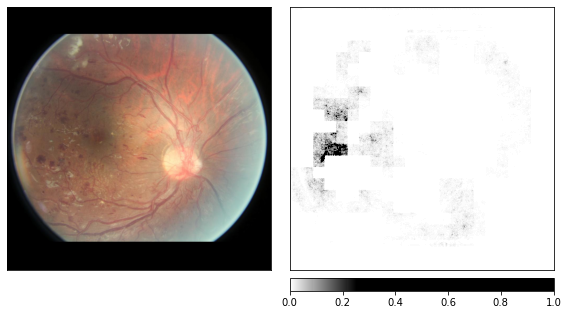

In [32]:
from matplotlib.colors import LinearSegmentedColormap
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


_ = viz.visualize_image_attr_multiple(att_image,
                                      normalized_img,
                                     ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)